<a href="https://colab.research.google.com/github/Sameetdmr/Sayisal-Goruntu-Isleme/blob/master/15541049_Samed_Demir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from keras.preprocessing.image import save_img

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


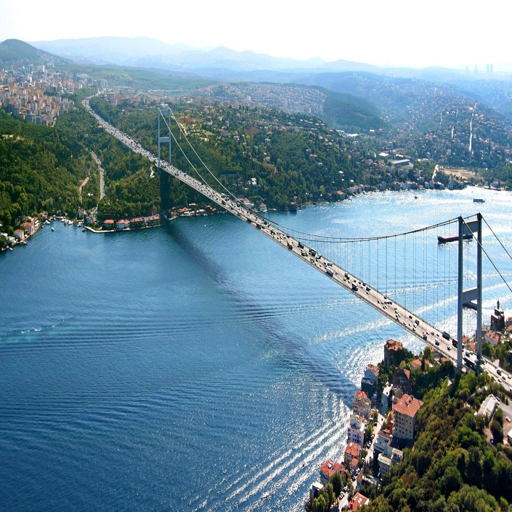

In [0]:
yükseklik = 512
genislik = 512

Anadizin = 'drive/My Drive/GoruntuIslemeProjesi/'
FotografYolu = Anadizin + 'Resimler/Sahil.jpg'
Fotograf = Image.open(FotografYolu)
Fotograf = Fotograf.resize((genislik, yükseklik))
Fotograf

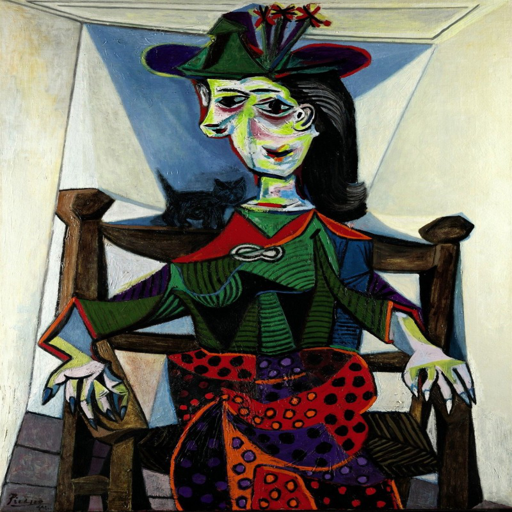

In [0]:
StilFotografYolu = Anadizin+'Stiller/pablopicasso.jpg'
StilFotografı = Image.open(StilFotografYolu)
StilFotografı = StilFotografı.resize((genislik, yükseklik))
StilFotografı

In [0]:
content_array = np.asarray(Fotograf, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(StilFotografı, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [0]:
Fotograf = backend.variable(content_array)
StilFotografı = backend.variable(style_array)
combination_image = backend.placeholder((1, yükseklik, genislik, 3))

In [0]:
input_tensor = backend.concatenate([Fotograf,
                                    StilFotografı,
                                    combination_image], axis=0)

In [0]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [0]:

Fotograf_Agirligi = 0.050
Stil_Agirligi = 10.0
total_variation_weight = 1.0

In [0]:

loss = backend.variable(0.)

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss =loss + Fotograf_Agirligi * content_loss(content_image_features,
                                      combination_features)

In [0]:

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [0]:

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = yükseklik * genislik
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (Stil_Agirligi / len(feature_layers)) * sl

In [0]:

def total_variation_loss(x):
    a = backend.square(x[:, :yükseklik-1, :genislik-1, :] - x[:, 1:, :genislik-1, :])
    b = backend.square(x[:, :yükseklik-1, :genislik-1, :] - x[:, :yükseklik-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss =loss+ total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = backend.gradients(loss, combination_image)

In [0]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, yükseklik, genislik, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [0]:
x = np.random.uniform(0, 255, (1, yükseklik, genislik, 3)) - 128.

sayac = 10

for i in range(sayac):
    print('Yapılan deneme', i)
    baslangıc_zamani = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Şuan oluşan kayıp değeri:', min_val)
    bitis_zamani = time.time()
    print('Deneme %d bitti ve %ds sürdü' % (i, bitis_zamani - baslangıc_zamani))

Yapılan deneme 0
Şuan oluşan kayıp değeri: 186244000000.0
Deneme 0 bitti ve 16s sürdü
Yapılan deneme 1
Şuan oluşan kayıp değeri: 91571960000.0
Deneme 1 bitti ve 6s sürdü
Yapılan deneme 2
Şuan oluşan kayıp değeri: 68038510000.0
Deneme 2 bitti ve 6s sürdü
Yapılan deneme 3
Şuan oluşan kayıp değeri: 53811466000.0
Deneme 3 bitti ve 6s sürdü
Yapılan deneme 4
Şuan oluşan kayıp değeri: 42438844000.0
Deneme 4 bitti ve 6s sürdü
Yapılan deneme 5
Şuan oluşan kayıp değeri: 35517424000.0
Deneme 5 bitti ve 6s sürdü
Yapılan deneme 6
Şuan oluşan kayıp değeri: 31336930000.0
Deneme 6 bitti ve 6s sürdü
Yapılan deneme 7
Şuan oluşan kayıp değeri: 29270180000.0
Deneme 7 bitti ve 6s sürdü
Yapılan deneme 8
Şuan oluşan kayıp değeri: 28246151000.0
Deneme 8 bitti ve 7s sürdü
Yapılan deneme 9
Şuan oluşan kayıp değeri: 27686350000.0
Deneme 9 bitti ve 6s sürdü


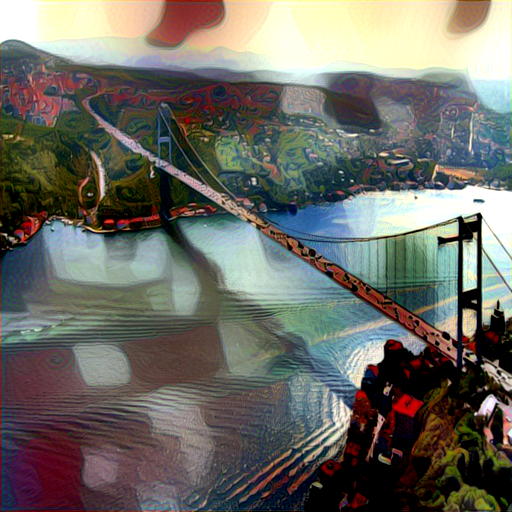

In [0]:
x = x.reshape((yükseklik, genislik, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)